### Installing Qiskit

In [2]:
%pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer
# %pip install qiskit_aer-gpu

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 2.7 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


### Libraries Importing


In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import Aer 
from sympy import *
import json, time

simulation_time = time.time() # to cont

# service = QiskitRuntimeService() # for real quantum computer

backend = Aer.get_backend('qasm_simulator') # for simulator
# backend = service.backend("ibm_osaka") # for real quantum
# backend = service.backend("simulator_mps") # for ibm simulator

init_printing()


### Problem Definition

In [45]:
conf = json.load(open("conf_6.json","r"))

In [67]:
N = conf["N"] # Number of Teachers
M = conf["M"] # Number of Classes
H = conf["H"] # Number of hours in week


random_seed = conf["random_seed"]
shots = conf["shots"] * 5
# layers = conf["layers"]
layers = 5

required_qubits = (M * N * H) + (M * H) + (N * H)
iterations = 0

print("Requried Qubits: ", required_qubits)

Requried Qubits:  6


In [68]:
# T_i is binary string denoting the available hours for each i Teacher
# C_j is binary string denoting the available hours for each j Class

T = conf["T"]
C = conf["C"]

R = conf["R"] # R_ij must be either 0 or 1

terms_count = 0
equations = []

### Formulation

#### Equations

In [69]:
for i in range(1, N + 1):
  for j in range(1, M + 1):
    temp = total = 0
    for h in range(1, H + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp - R[i-1][j-1])**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [70]:
for j in range(1, M + 1):
  for h in range(1, H + 1):
    temp = total = 0
    for i in range(1, N + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp + symbols(f"τ_{j}{h}") - 1)**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [71]:
for i in range(1, N + 1):
  for h in range(1, H + 1):
    temp = total = 0
    for j in range(1, M + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp + symbols(f"λ_{i}{h}") - 1)**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [72]:
terms_count

#### Decodeing Equations

In [73]:
def args(equation):
  return Add.make_args(equation)

def prepare_equation(term):
  theta = 1
  terms = []
  if type(term) == Mul:
    for i in term.args:
      if i.is_Integer:
        theta = i
      else:
        terms.append(i)
  else:
    terms.append(term.args[0]) 

  return [theta, decode(terms)]

def decode(terms):
  output = []

  for term in terms:

    term = str(term)

    if term.startswith("τ"):
      j = int(term[2])
      h = int(term[3])
      output.append((h-1) * M + (j - 1))


    elif term.startswith("λ"):
      i = int(term[2])
      h = int(term[3])
      output.append((H * M) + ((h-1) * N + (i - 1)))

    elif term.startswith("f"):
      i = int(term[2])
      j = int(term[3])
      h = int(term[4])
      output.append((H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1))

  return output


In [74]:
prepared_equations = []
for equation in equations:
  temp = []
  for term in args(equation):
    if len(term.args) != 0:
      temp.append(prepare_equation(term))
  prepared_equations.append(temp)

prepared_equations

### Implementation

#### Objective Function

In [75]:
def f(i, j, h):
  return int(T[i-1][h-1] == C[j-1][h-1] == '1')

def tau_value(bit_string, j, h):
  return int(bit_string[(h-1) * M + (j - 1)])

def lambda_value(bit_string, i, h):
  return int(bit_string[(H * M) + ((h-1) * N + (i - 1))])

def f_value(bit_string, i, j, h):
  return int(bit_string[(H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1)])


In [76]:
def objective(bit_string):
  bit_string = bit_string[::-1] # since qiskit represent solution in least significant bit format 
  cost = 0
  a = b = c = d = 0
  # equation a
  for i in range(1, N + 1):
    for j in range(1, M + 1):
      for h in range(1, H + 1):
        if f(i, j, h) != f_value(bit_string, i, j, h):
          cost += 1
          a += 1

  # equation b
  for i in range(1, N + 1):
    for j in range(1, M + 1):
      temp = 0
      for h in range(1, H + 1):
        temp += f_value(bit_string, i, j, h)
      cost += (temp - R[i-1][j-1])**2
      b += (temp - R[i-1][j-1])**2

  # equation c
  for j in range(1, M + 1):
    for h in range(1, H + 1):
      temp = 0
      for i in range(1, N + 1):
        temp += f_value(bit_string, i, j, h)
      cost += (temp + tau_value(bit_string, j, h) - 1)**2
      c += (temp + tau_value(bit_string, j, h) - 1)**2

  # equation d
  for i in range(1, N + 1):
    for h in range(1, H + 1):
      temp = 0
      for j in range(1, M + 1):
        temp += f_value(bit_string, i, j, h)
      cost += (temp + lambda_value(bit_string, i, h) - 1)**2
      d += (temp + lambda_value(bit_string, i, h) - 1)**2

  return [cost, a, b, c, d]

In [77]:
temp = ["0"] * required_qubits

for i in range(1, N + 1):
    for j in range(1, M + 1):
        for h in range(1, H + 1):
            temp[(H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1)] = str(f(i, j, h))  

# equation c
for j in range(1, M + 1):
    for h in range(1, H + 1):
        for i in range(1, N + 1):
            if f(i, j, h) == 0:
                temp[(h-1) * M + (j - 1)] = "1"

# equation d
for i in range(1, N + 1):
    for h in range(1, H + 1):
        for j in range(1, M + 1):
            if f(i, j, h) == 0:
                temp[(H * M) + ((h-1) * N + (i - 1))] = "1"

initial_solution = "".join(temp)
objective(initial_solution[::-1])

#### Circuit

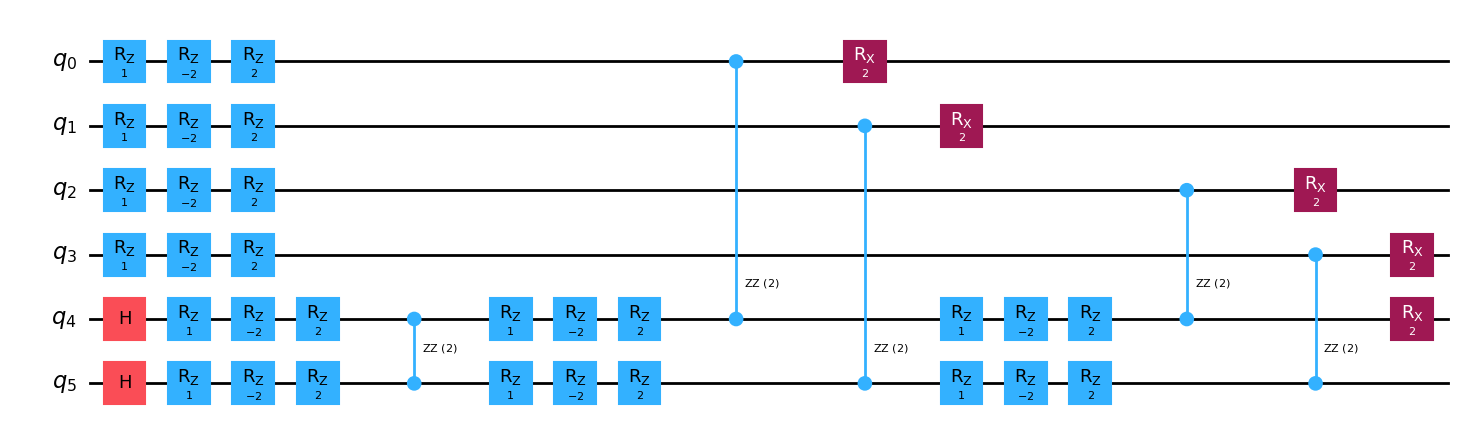

In [78]:
# qc = QuantumCircuit(required_qubits)

# for i in range((M*H) + (N * H),required_qubits):
#     qc.h(i)

# for equation in prepared_equations:
#   for term in equation:
#     theta = int(term[0])
#     locations = term[1]
#     if len(locations) == 1: # i.e. trivial term
#         qc.rz(theta, locations[0])
#     elif len(locations) == 2:
#         qc.rz(theta, locations[0])
#         qc.rz(theta, locations[1]) 
#         qc.rzz(theta, locations[0], locations[1])

# for qubit in range(required_qubits - 1):
#     qc.rx(2  , qubit)

# qc.draw("mpl")


In [79]:
def layers_gen(p, initial_value = 1.0):
  return [initial_value] * p * 2

def create_qaoa_circ(theta):
    n_layers = len(theta)//2

    alpha = theta[n_layers:]
    gamma = theta[:n_layers]

    qc = QuantumCircuit(required_qubits)

    for i in range(required_qubits): # 
      qc.h(i)
      # if initial_solution[i]=="1":
      #   qc.x(i)

    for layer_index in range(n_layers):
        # print(f"alpha{layer_index}", alpha[layer_index])
        # print(f"gamma{layer_index}", gamma[layer_index])
        for equation in prepared_equations:
          for term in equation:
            theta = int(term[0])
            locations = term[1]
            if len(locations) == 1: # i.e. trivial term
                qc.rz(theta * 0.5 * alpha[layer_index], locations[0])

            elif len(locations) == 2:
                qc.rz(theta * -0.25 * alpha[layer_index], locations[0]) # -1/4 * z1 = -1/4 * z1
                qc.rz(theta * -0.25 * alpha[layer_index], locations[1]) # -1/4 * z2 = -1/4 * z2
                qc.rzz(theta * 0.25 * alpha[layer_index], locations[0], locations[1]) # -1/4 * -z1z2 = 1/4 * z1z2

        for qubit in range(required_qubits - 1):
            qc.rx(2 * gamma[layer_index] , qubit)

    qc.measure_all()
    
    return qc

In [80]:
total = [0] * 5
def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj,a,b,c,d = objective(bit_string)
        total[0] += a
        total[1] += b
        total[2] += c
        total[3] += d
        avg += obj * count
        sum_count += count


    return avg/sum_count

def get_expectation():

    def execute_circ(theta):
        global iterations
        qc = create_qaoa_circ(theta)
        tc = transpile(qc,backend,optimization_level=3,seed_transpiler=random_seed)
        counts = backend.run(tc, seed_simulator=random_seed, shots=shots).result().get_counts()
        print(compute_expectation(counts))
        iterations += 1
        return compute_expectation(counts)

    return execute_circ

In [81]:
from scipy.optimize import minimize,differential_evolution
expectation = get_expectation()
start_time = time.time()
res = minimize(expectation, layers_gen(layers), method='COBYLA') 
minimization_time = time.time() - start_time

res

2.767578125
3.6529296875
3.4349609375
3.6236328125
3.3990234375
4.1169921875
3.0837890625
2.8509765625
3.68046875
2.894921875
4.0697265625
4.375390625
3.2455078125
3.03203125
2.644140625
2.8828125
2.451171875
2.321875
2.3181640625
2.301953125
2.1234375
2.1068359375
2.267578125
2.3326171875
2.236328125
2.3431640625
2.2908203125
2.0720703125
2.239453125
2.2099609375
2.188671875
2.217578125
2.044140625
2.040625
2.0134765625
2.0646484375
2.0638671875
2.05078125
1.9806640625
1.9921875
2.1291015625
1.9298828125
1.9142578125
1.9185546875
1.958203125
1.965625
1.93046875
1.9115234375
1.9578125
1.9203125
1.931640625
1.9072265625
1.953515625
1.9158203125
1.89609375
1.9265625
1.8802734375
1.8982421875
1.8876953125
1.88203125
1.8888671875
1.878125
1.8943359375
1.8806640625
1.891015625
1.88359375
1.8953125
1.881640625
1.8806640625
1.8822265625
1.887109375
1.8849609375
1.88125
1.884765625
1.8802734375
1.887109375
1.8828125
1.879296875
1.877734375
1.877734375
1.8802734375
1.8802734375
1.8818359375
1.8

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.87734375
       x: [ 6.780e-01  1.193e+00  5.754e-01  1.549e+00  1.047e+00
            1.027e+00  1.045e+00  1.021e+00  1.059e+00  1.037e+00]
    nfev: 124
   maxcv: 0.0

In [82]:
print("a:",total[0])
print("b:",total[1])
print("c:",total[2])
print("d:",total[3])

a: 13638
b: 6902
c: 13480
d: 13622


### Results

54
-----------------
BINGO
011010
485
-----------------
Solution 110000 cost: 2 count 1151
Solution 100101 cost: 2 count 651
Solution 010000 cost: 2 count 506
Solution 010010 cost: 1 count 495
Solution 011000 cost: 1 count 489
Solution 011010 cost: 0 count 485
Solution 111000 cost: 3 count 176
Solution 110010 cost: 3 count 174
Solution 101101 cost: 3 count 110
Solution 001101 cost: 3 count 97


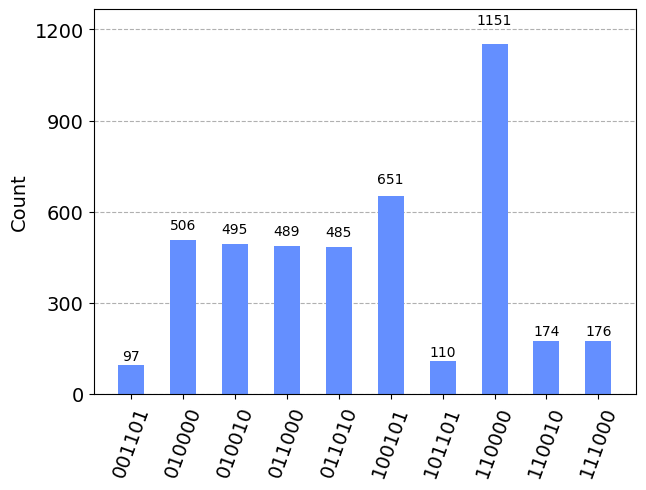

In [88]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(res.x)
counts = backend.run(qc_res, seed_simulator=random_seed, shots=shots).result().get_counts()


counts = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
counts_cost = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))

values = list(counts.values())
binary = list(counts.keys())

output = {}

print(len(counts))

for key in binary:
  if objective(key)[0] == 0:
    print("-----------------")
    print("BINGO")
    print(key)
    print(counts[key])
    print("-----------------")

for key in binary[:10]:
    print("Solution",key ,"cost:",objective(key)[0],"count", counts[key])
    output[key] = counts[key]

plot_histogram(output)

In [84]:
sol = required_qubits
sol_bin = ""

for i in counts:
  ob = objective(i)[0]
  if ob < sol:
    sol = ob
    sol_bin = i

counts["H"] = H
counts["M"] = M
counts["N"] = N
counts["shots"] = shots
counts["layers"] = layers
counts["solution"] = sol_bin
counts["solution_cost"] = sol
counts["solution_count"] = counts[sol_bin]
counts["minimization_time"] = minimization_time
counts["execution_time"] = time.time() - simulation_time
counts["iterations"] = iterations 

print("Solution",sol_bin ,"cost:",sol,"count", counts[sol_bin])

Solution 011010 cost: 0 count 485


In [85]:
file = open(f"./json/{H}_{M}_{N}_{shots}_{layers}_{time.time_ns()}.json", "w")
file.write(json.dumps(counts))
file.flush()

In [86]:
counts["execution_time"]

In [87]:
minimization_time